In [22]:
#Este projeto treina usando todas as casas e usando o método 
from __future__ import print_function, division
import time
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six import iteritems
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
import nilmtk.utils


%matplotlib inline

#Tamanho das figuras
rcParams['figure.figsize'] = (13, 6)

In [23]:
#Demonstração do funcionamento do nosso banco de dados
import unifei
from unifei.convert_unifei import convert_unifei
from nilmtk.utils import print_dict

convert_unifei(r'medicao_unifei', 'banco_unifei.h5')

unifei = DataSet('banco_unifei.h5')
print_dict(unifei.metadata)

[1, 2, 3]
Loading house 1... [1, 2, 3]
1 2 3 
Loading house 2... [1, 2, 3]
1 2 3 
Loading house 3... [1, 2, 3]
1 2 3 
Done convert...
C:\Users\Leona\anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk
C:\Users\Leona\anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\dataset_converters\unifei\metadata
Loaded metadata
{'SM_W_Lite': {'model': 'SM_W_Lite', 'manufacturer': 'IETECNOLOGIA', 'manufacturer_url': 'https://ietecnologia.com/', 'description': 'Medidor de energia monofásico wifi modelo SM-W Lite; Tenha em mãos os gastos de sua casa em tempo real, 24 horas por dia; Apresenta em tempo real os gráficos de corrente [A], Consumo [kWh] e Consumo [R$]; Equipamento Nacional; Mostra em tempo real o quanto sua casa está consumindo em reais\n', 'sample_period': 5, 'max_sample_period': 50, 'measurements': [{'physical_quantity': 'power', 'type': 'active', 'upper_limit': 5000, 'lower_limit': 0}], 'wireless': True}, 'SM_3W': {'model': 'SM_3W', 'manufacturer': 'IETECNOLOGIA', 'manufacturer_url': 'ht

In [24]:
print_dict(unifei.buildings)

In [25]:
fridge = unifei.buildings[1].elec['fridge']
df = next(fridge.load())
df

physical_quantity,power
type,active
2020-10-14 21:19:02-03:00,0.0
2020-10-14 21:19:07-03:00,0.0
2020-10-14 21:19:13-03:00,0.0
2020-10-14 21:19:18-03:00,0.0
2020-10-14 21:19:23-03:00,0.0
...,...
2020-11-04 20:43:11-03:00,0.0
2020-11-04 20:43:16-03:00,0.0
2020-11-04 20:43:22-03:00,0.0


In [26]:
#from redd.convert_redd import convert_redd
#convert_redd(r'low_freq', 'redd.h5')

In [27]:
#Carrega os dados na memória
train = DataSet('banco_unifei.h5')
test = DataSet('banco_unifei.h5')

train.buildings[3].elec.meters

[ElecMeter(instance=1, building=3, dataset='Unifei', site_meter, appliances=[]),
 ElecMeter(instance=2, building=3, dataset='Unifei', appliances=[Appliance(type='fridge', instance=1)]),
 ElecMeter(instance=3, building=3, dataset='Unifei', appliances=[Appliance(type='electric shower heater', instance=1)])]

In [28]:
#Enumera todas as casas
buildings = [ i for i in range(3)]

In [29]:
# The dates are interpreted by Pandas, prefer using ISO dates (yyyy-mm-dd)
train.set_window(end="2020-10-29")
test.set_window(start="2020-10-30")

#Vetor que guarda os dados de todas as casas
train_elec = [None for i in range(3)]
test_elec = [None for i in range(3)]

for building in buildings:
    train_elec[building] = train.buildings[building+1].elec
    test_elec[building] = test.buildings[building+1].elec

In [30]:
#Este valor é dado em kwh
test_elec[0].mains()

ElecMeter(instance=1, building=1, dataset='Unifei', site_meter, appliances=[])

In [31]:
#Energia por cada medidor em kwh
energy_per_meter = test_elec[2].submeters().energy_per_meter() # kWh, again
energy_per_meter

2/2 ElecMeter(instance=3, building=3, dataset='Unifei', appliances=[Appliance(type='electric shower heater', instance=1)])

,"(2, 3, Unifei)","(3, 3, Unifei)"
active,6.433765,14.126941
apparent,NaN,NaN
reactive,NaN,NaN


In [32]:
#Seleciona as top 5 aplicações de cada casa
top_5_train_elec = [None for i in range(3)]

for building in buildings:
    top_5_train_elec[building] = train_elec[building].submeters().select_top_k(k=2)

2/2 ElecMeter(instance=3, building=3, dataset='Unifei', appliances=[Appliance(type='electric shower heater', instance=1)])

C:\Users\Leona\anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\utils.py:502: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")
C:\Users\Leona\anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\utils.py:502: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


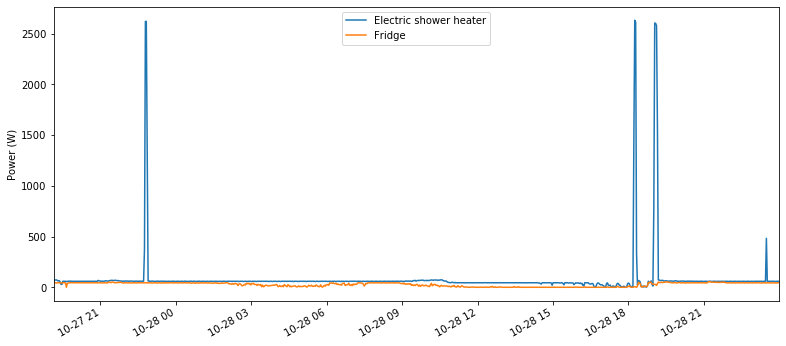

In [40]:
top_5_train_elec[2].plot()

In [34]:
def predict(clf, test_elec, sample_period, timezone):
    pred = {}
    gt= {}

    for i, chunk in enumerate(test_elec.mains().load(sample_period=sample_period)):
        print(i)
        chunk_drop_na = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

        for meter in test_elec.submeters().meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = next(meter.load(sample_period=sample_period))
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i]) if len(v)}, index=next(iter(gt[i].values())).index).dropna()
        
    # If everything can fit in memory
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()
    
    
    # Having the same order of columns
    gt_overall = gt_overall[pred_overall.columns]
    
    #Intersection of index
    gt_index_utc = gt_overall.index.tz_convert("UTC")
    pred_index_utc = pred_overall.index.tz_convert("UTC")
    common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
    
    common_index_local = common_index_utc.tz_convert(timezone)
    gt_overall = gt_overall.loc[common_index_local]
    pred_overall = pred_overall.loc[common_index_local]
    appliance_labels = [m for m in gt_overall.columns.values]
    gt_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels
    
    return gt_overall, pred_overall

In [35]:
# Since the methods use randomized initialization, let's fix a seed here
# to make this notebook reproducible
import numpy.random
numpy.random.seed(42)

In [36]:
sample_period = 120 
predictions = []
gts = []
fhmm = FHMM()

for building in buildings:
    print('*' * 20 )
    print('Casa : {}'.format(building))
    print('Usando o metodo FHHM...')
    print('*' * 20 )
    fhmm.train(top_5_train_elec[building], sample_period=sample_period)
    
    gt, prediction = predict(fhmm, test_elec[building], sample_period, train.metadata['timezone'])
    gts.append(gt)
    predictions.append(prediction)

********************
Casa : 0
Usando o metodo FHHM...
********************


C:\Users\Leona\anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\utils.py:502: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


Training model for submeter 'ElecMeter(instance=2, building=1, dataset='Unifei', appliances=[Appliance(type='fridge', instance=1)])' with 3 states


C:\Users\Leona\anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\utils.py:502: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


Training model for submeter 'ElecMeter(instance=3, building=1, dataset='Unifei', appliances=[Appliance(type='coffee maker', instance=1)])' with 3 states
0
********************
Casa : 1
Usando o metodo FHHM...
********************


C:\Users\Leona\anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\utils.py:502: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


Training model for submeter 'ElecMeter(instance=2, building=2, dataset='Unifei', appliances=[Appliance(type='fridge', instance=1)])' with 3 states


C:\Users\Leona\anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\utils.py:502: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


Training model for submeter 'ElecMeter(instance=3, building=2, dataset='Unifei', appliances=[Appliance(type='washing machine', instance=1)])' with 3 states


C:\Users\Leona\anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\utils.py:502: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")
C:\Users\Leona\anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\utils.py:502: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


0
********************
Casa : 2
Usando o metodo FHHM...
********************
Training model for submeter 'ElecMeter(instance=3, building=3, dataset='Unifei', appliances=[Appliance(type='electric shower heater', instance=1)])' with 3 states


C:\Users\Leona\anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\utils.py:502: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


Training model for submeter 'ElecMeter(instance=2, building=3, dataset='Unifei', appliances=[Appliance(type='fridge', instance=1)])' with 3 states


C:\Users\Leona\anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\utils.py:502: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")
C:\Users\Leona\anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\utils.py:502: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


0


In [37]:
for i in range(3):
    appliance_labels = [m.label() for m in gts[i].columns.values]
    gts[i].columns = appliance_labels
    predictions[i].columns = appliance_labels

In [38]:
print(predictions[0].columns)

Index(['Fridge', 'Coffee maker'], dtype='object')


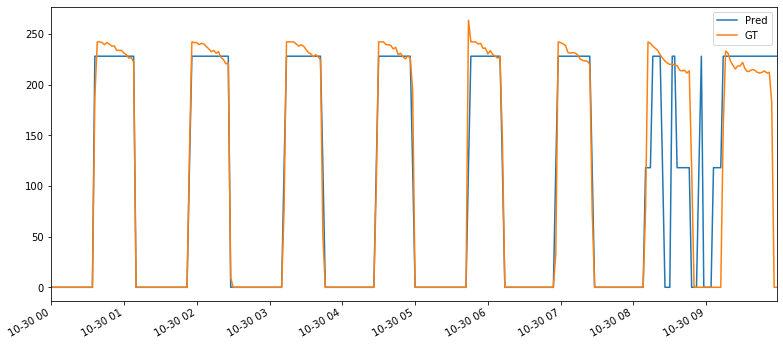

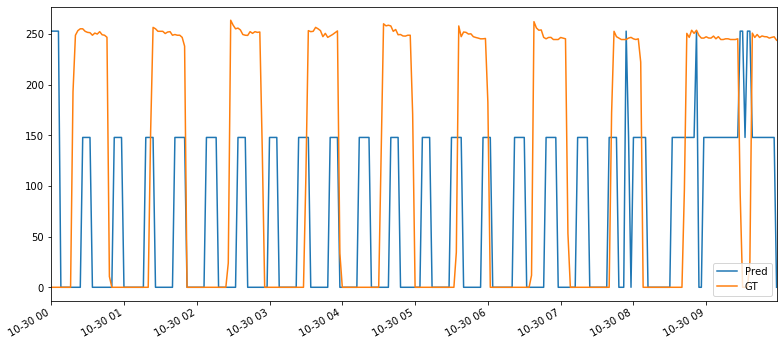

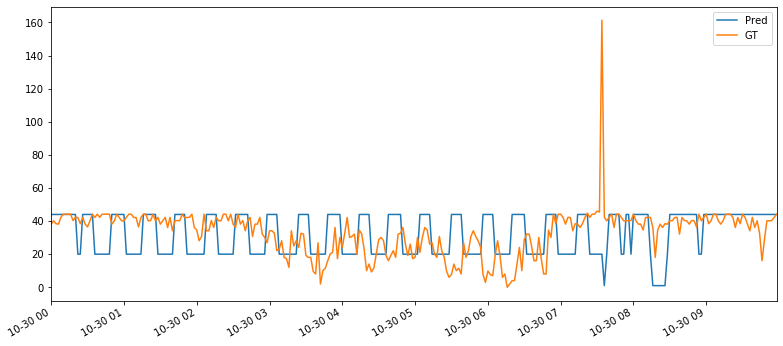

In [39]:
for i in range(3):
    plt.subplots(1)
    predictions[i]['Fridge'].head(300).plot(label="Pred")
    gts[i]['Fridge'].head(300).plot(label="GT")
    plt.legend()


In [ ]:
#Imprimindo todas as predições feitas para a casa 1
'''for building in range(3):
    for appliance in predictions[building]:
        plt.subplots(1)
        predictions[building][appliance].head(300).plot(label=appliance)
        gts[building][appliance].head(300).plot(label="GT")
        plt.legend()'''
predictions[0]['Sockets']

In [ ]:
#testar as aplicações em 36 segundos
#Amostra retiradas da casa 


casa_1 = 0
sample_period = 72 #faz o down_sample para amostras a cada 36 segundos pq as as amostras são de 3 ou 4 segundos
predictions = []
gts = []
fhmm = FHMM()
fhmm.train(top_5_train_elec[casa_1], sample_period=sample_period)
gt, prediction = predict(fhmm, test_elec[casa_1], sample_period, train.metadata['timezone'])
    

In [ ]:
def imprime_casa():
    appliance_labels = [m.label() for m in gt.columns.values]
    gt.columns = appliance_labels
    prediction.columns = appliance_labels

    #Imprime as medições
    for appliance in prediction:
            plt.subplots(1)
            prediction[appliance].head(300).plot(label=appliance)
            gt[appliance].head(300).plot(label="GT")
            plt.legend()

In [ ]:
imprime_casa()

In [ ]:
#testar as aplicações em 24 segundos para todos os algoritmos no NILMTK
#Amostra retiradas da casa 


casa_1 = 0
sample_period = 48 #faz o down_sample para amostras a cada 24 segundos pq as as amostras são de 3 ou 4 segundos
predictions = []
gts = []
fhmm = FHMM()
fhmm.train(top_5_train_elec[casa_1], sample_period=sample_period)
gt, prediction = predict(fhmm, test_elec[casa_1], sample_period, train.metadata['timezone'])
    

In [2]:
imprime_casa()
        

NameError: name 'imprime_casa' is not defined

In [3]:
#CombinatorialOptimisation
sample_period = 48 #faz o down_sample para amostras a cada 24 segundos pq as as amostras são de 3 ou 4 segundos
predictions = []
gts = []
co = CombinatorialOptimisation()
co.train(top_5_train_elec[casa_1], sample_period=sample_period)
gt, prediction = predict(co, test_elec[casa_1], sample_period, train.metadata['timezone'])

NameError: name 'top_5_train_elec' is not defined

In [4]:
imprime_casa()

NameError: name 'imprime_casa' is not defined

In [5]:
#Treinar com poucos dias
train.set_window(end="2011-04-19")
test.set_window(start="2011-04-19")

train_casa_1 = train.buildings[1].elec
test_casa_1 = test.buildings[1].elec

top_5_casa_1 = train_casa_1.submeters().select_top_k(k=5)

sample_period = 48 
predictions = []
gts = []
fhmm = FHMM()

fhmm.train(top_5_casa_1, sample_period=sample_period)
gt, prediction = predict(fhmm, test_casa_1, sample_period, train.metadata['timezone'])

imprime_casa()


NameError: name 'train' is not defined

In [6]:
#Treinar com poucos dias
#Tentar usar a biblioteca tensorflow
# The dates are interpreted by Pandas, prefer using ISO dates (yyyy-mm-dd)
train.set_window(end="2011-04-25")
test.set_window(start="2011-04-25")

train_casa_1 = train.buildings[1].elec
test_casa_1 = test.buildings[1].elec

top_5_casa_1 = train_casa_1.submeters().select_top_k(k=5)

sample_period = 48 
predictions = []
gts = []
fhmm = FHMM()

fhmm.train(top_5_casa_1, sample_period=sample_period)
gt, prediction = predict(fhmm, test_casa_1, sample_period, train.metadata['timezone'])

imprime_casa()


NameError: name 'train' is not defined

In [7]:
#Treinar com poucos dias
#Tentar usar a biblioteca tensorflow
train.set_window(end="2011-05-10")
test.set_window(start="2011-05-10")

train_casa_1 = train.buildings[1].elec
test_casa_1 = test.buildings[1].elec

top_5_casa_1 = train_casa_1.submeters().select_top_k(k=5)

sample_period = 48 
predictions = []
gts = []
fhmm = FHMM()

fhmm.train(top_5_casa_1, sample_period=sample_period)
gt, prediction = predict(fhmm, test_casa_1, sample_period, train.metadata['timezone'])

imprime_casa()

NameError: name 'train' is not defined

In [8]:
#Definição de uma função que é capaz de encontrar o valor da energia predita em cada caso
prediction

NameError: name 'prediction' is not defined

In [9]:
top_5_casa_1.energy_per_meter()

NameError: name 'top_5_casa_1' is not defined

In [ ]:
from nilmtk.stats.totalenergy import _energy_for_power_series
objetos = ['Fridge', 'Light', 'Washer dryer', 'Sockets', 'Dish washer']
energias = {}

for objeto in objetos:
    aux = _energy_for_power_series(prediction.loc[:, objeto], 60)
    energias[objeto] = aux

energias